# Assingment 2 - Tumor segmentation
### Course: Convolutional Neural Networks with Applications in Medical Image Analysis

Previously you have looked at the different available contrasts of the same anatomy, but the dataset also contains a manually segmented binary map of a tumor, if visible on the slice. For the second assignment your task is to create a tumor segmentation model that takes any number of image contrasts as an input, and outputs the tumor segmentations. For this task, you will implement and use the [DICE](https://en.wikipedia.org/wiki/S%C3%B8rensen%E2%80%93Dice_coefficient) score to evaluate (aim for a DICE score higher than $0.8$ on the validation set).

Your task is to look through the highly customizable code below, which contains all the main steps for image segmentation from using only one contrast as an input. By changing the arrays of the DataGenerator, multiple contrasts can be added as input, similar as in Assignment 1. The most important issues with the current code are noted in the comments for easier comprehension. Your tasks, to include in the Jupyter notebook you hand in, are:
- How you reached the required performances (DICE score above 0.8)
- Plot the training/validating losses and accuracies. Describe when to stop training, and why that is a good choice.
- Once you have reached the required loss on the validation data, and you have selected your final model, only then evaluate your model on the testing data as well.
- Describe the thought process behind building your model and choosing the model hyper-parameters.
- Describe what you think are the biggest issues with the provided network and training, and how you solved them.

Upload the updated notebook to Canvas by March $31^{th}$, 15:00.

Good luck and have fun!

In [140]:
import os

import numpy as np
np.random.seed(2022)  # Set seed for reproducibility

import tensorflow as tf
tf.random.set_seed(2022)

import random
random.seed(2022)

from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
import tensorflow.keras as keras

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if len(gpus) > 0:
    tf.config.experimental.set_memory_growth(gpus[0], True)
    print(f"GPU(s) available (using '{gpus[0].name}'). Training will be lightning fast!")
else:
    print("No GPU(s) available. Training will be suuuuper slow!")

# release gpu mem
keras.backend.clear_session()
    
# NOTE: These are the packages you will need for the assignment.
# NOTE: You are encouraged to use the course virtual environment, which already has GPU support.

GPU(s) available (using '/physical_device:GPU:0'). Training will be lightning fast!


##### The cell below will define the data generator for the data you will be using. You should not change anything in the below code!

In [141]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self,
                 data_path,
                 arrays,
                 batch_size=32,
                 ):

        self.data_path = data_path
        self.arrays = arrays
        self.batch_size = batch_size

        if data_path is None:
            raise ValueError('The data path is not defined.')

        if not os.path.isdir(data_path):
            raise ValueError('The data path is incorrectly defined.')

        self.file_idx = 0
        self.file_list = [self.data_path + '/' + s for s in
                          os.listdir(self.data_path)]
        
        self.on_epoch_end()
        with np.load(self.file_list[0]) as npzfile:
            self.in_dims = []
            self.n_channels = 1
            for i in range(len(self.arrays)):
                im = npzfile[self.arrays[i]]
                self.in_dims.append((self.batch_size,
                                    *np.shape(im),
                                    self.n_channels))

    def __len__(self):
        """Get the number of batches per epoch."""
        return int(np.floor((len(self.file_list)) / self.batch_size))

    def __getitem__(self, index):
        """Generate one batch of data."""
        # Generate indexes of the batch
        indexes = self.indexes[index * self.batch_size:(index + 1) *
                               self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.file_list[k] for k in indexes]

        # Generate data
        a = self.__data_generation(list_IDs_temp)
        return a

    def on_epoch_end(self):
        """Update indexes after each epoch."""
        self.indexes = np.arange(len(self.file_list))
        np.random.shuffle(self.indexes)
    
    #@threadsafe_generator
    def __data_generation(self, temp_list):
        """Generate data containing batch_size samples."""
        # X : (n_samples, *dim, n_channels)
        # Initialization
        arrays = []

        for i in range(len(self.arrays)):
            arrays.append(np.empty(self.in_dims[i]).astype(np.single))

        for i, ID in enumerate(temp_list):
            with np.load(ID) as npzfile:
                for idx in range(len(self.arrays)):
                    x = npzfile[self.arrays[idx]] \
                        .astype(np.single)
                    x = np.expand_dims(x, axis=2)
                    arrays[idx][i, ] = x

        return arrays

# NOTE: Don't change the data generator!

In [142]:
gen_dir = "data/" #"/import/software/3ra023/vt22/brats/data/"  # Change if you have copied the data locally on your machine 
input_labels = ["flair", "t2"]
gt_label = "mask"
array_labels = input_labels + [gt_label]  # Available arrays are: 't1', 't1ce', 't2', 'flair', 'mask'.
batch_size = 4

gen_train = DataGenerator(data_path=gen_dir + "training",
                          arrays=array_labels,
                          batch_size=batch_size)

gen_val = DataGenerator(data_path=gen_dir + "validating",
                        arrays=array_labels,
                        batch_size=batch_size)

gen_test = DataGenerator(data_path=gen_dir + "testing",
                         arrays=array_labels,
                         batch_size=batch_size)

# NOTE: What arrays are you using? You can use multiple contrasts as inputs, if you'd like.
# NOTE: Which contrasts do you think are the best to use for tumor segmentation? Try plotting them all.
# NOTE: What batch size are you using? Should you use more? Or less?
# NOTE: Are you using the correct generators for the correct task? Training for training and validating for validating?

### Let's plot some example images from the dataset:

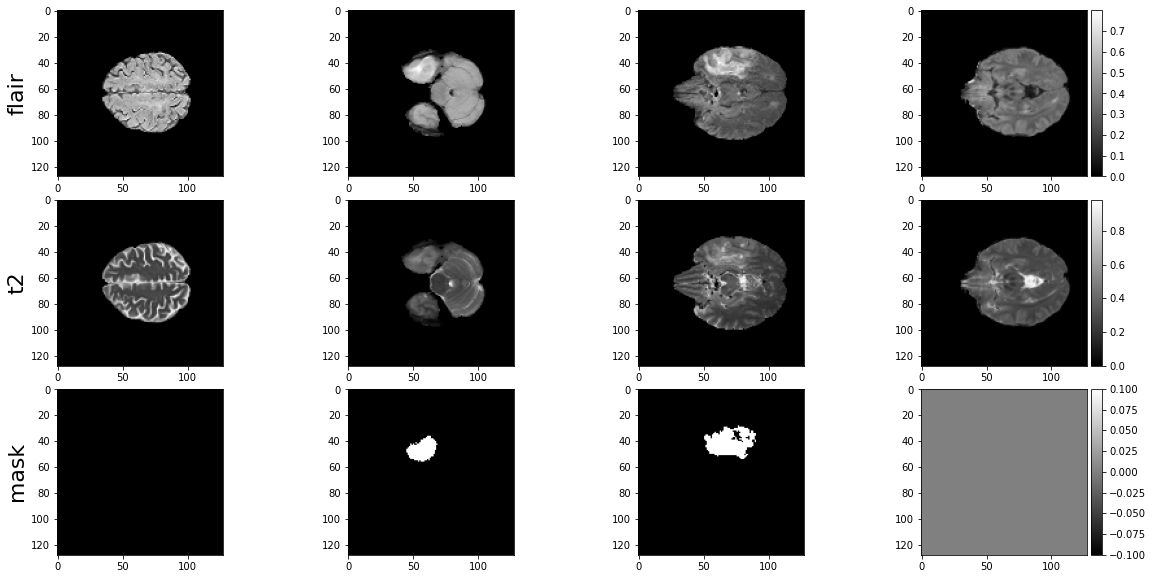

In [143]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

fig = plt.figure(figsize=(16.0, 8.0))
fig.subplots_adjust(left=0.001,
                    right=0.9975,
                    top=0.95,
                    bottom=0.005,
                    wspace=0.05,
                    hspace=0.14)

M, N = len(array_labels), 4
ax = []
for i in range(M):
    ax.append([None] * N)
    for j in range(N):
        ax[i][j] = plt.subplot2grid((M, N), (i, j), rowspan=1, colspan=1)

imgs = gen_train[5]
idx = [0,1,2,3]  # Plot images in mini-batch with these indices
ii = 0
for j in range(N):
    for i in range(M):
        im = ax[i][j].imshow(imgs[i][idx[ii], :, :, 0], cmap='gray')

        if j == 0:  # Label only on the left
            ax[i][j].set_ylabel(gen_train.arrays[i], fontsize=22)
        if j == N - 1:  # Colorbar only on the right
            divider = make_axes_locatable(ax[i][j])
            cax1 = divider.append_axes("right", size="7%", pad=0.05)
            cbar = plt.colorbar(im, cax=cax1)
    ii += 1    

A quick summary of the data sizes:

In [144]:
# A quick summary of the data:
print(f"Number of training images : {len(gen_train.file_list)}")
print(f"Training batch size       : {gen_train.in_dims}")

Number of training images : 8000
Training batch size       : [(4, 128, 128, 1), (4, 128, 128, 1), (4, 128, 128, 1)]


### The dataset preprocessing so far has been to help you, you should not change anything above. However, from now on, take nothing for granted.

In [145]:
# Import packages important for building and training your model.

import tensorflow.keras
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import Flatten, Input
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, concatenate, add
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Dropout, UpSampling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers

In [146]:
from tensorflow import Tensor
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, \
                                    Add, AveragePooling2D, Flatten, Dense, UpSampling2D
from tensorflow.keras.models import Model

def double_conv_block(x, filters, batch_norm = False):
    x = Conv2D(filters, 3, padding='same')(x)
    x = Activation('relu')(x)

    if batch_norm:
        x = BatchNormalization()(x)

    x = Conv2D(filters, 3, padding='same')(x)
    x = Activation('relu')(x)

    if batch_norm:
        x = BatchNormalization()(x)
    
    return x

def downsample_block(x, filters, dropout = 0.0, batch_norm = False):
    f = double_conv_block(x, filters, batch_norm)
    p = MaxPooling2D(2)(f)

    if dropout > 0.0:
        p = Dropout(dropout)(p)

    return f,p

def upsample_block(x, residual, filters, dropout = 0.0, batch_norm = False):
    x = Conv2DTranspose(filters, kernel_size=3, strides=2, padding='same')(x)
    x = concatenate([x, residual])

    if dropout > 0.0:
        x = Dropout(dropout)(x)

    x = double_conv_block(x, filters, batch_norm)
    
    return x

def build_model():
    start_filters = 32;

    inputs = Input(shape=(128, 128, 1))

    f1,p1 = downsample_block(inputs, start_filters)
    f2,p2 = downsample_block(p1, start_filters * 2, batch_norm=True)
    f3,p3 = downsample_block(p2, start_filters * 4, dropout=0.5, batch_norm=True)
    f4,p4 = downsample_block(p3, start_filters * 8, dropout=0.5, batch_norm=True)

    bottleneck = double_conv_block(p4, start_filters * 16, batch_norm=True)
    
    u1 = upsample_block(bottleneck, f4, start_filters * 8, batch_norm=True)
    u2 = upsample_block(u1, f3, start_filters * 4, batch_norm=True)
    u3 = upsample_block(u2, f2, start_filters * 2, dropout=0.5, batch_norm=True)
    u4 = upsample_block(u3, f1, start_filters, dropout=0.5, batch_norm=True)
    
    outputs = Conv2D(1, 1, activation='sigmoid', padding='same')(u4)
    
    return Model(inputs, outputs)

# NOTE: Be inspired by the imported layers.
# NOTE: Probably the most famous model architecture for segmentation is the U-Net.

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 9248        activation[0][0]                 
_______________________________________________________________________________________

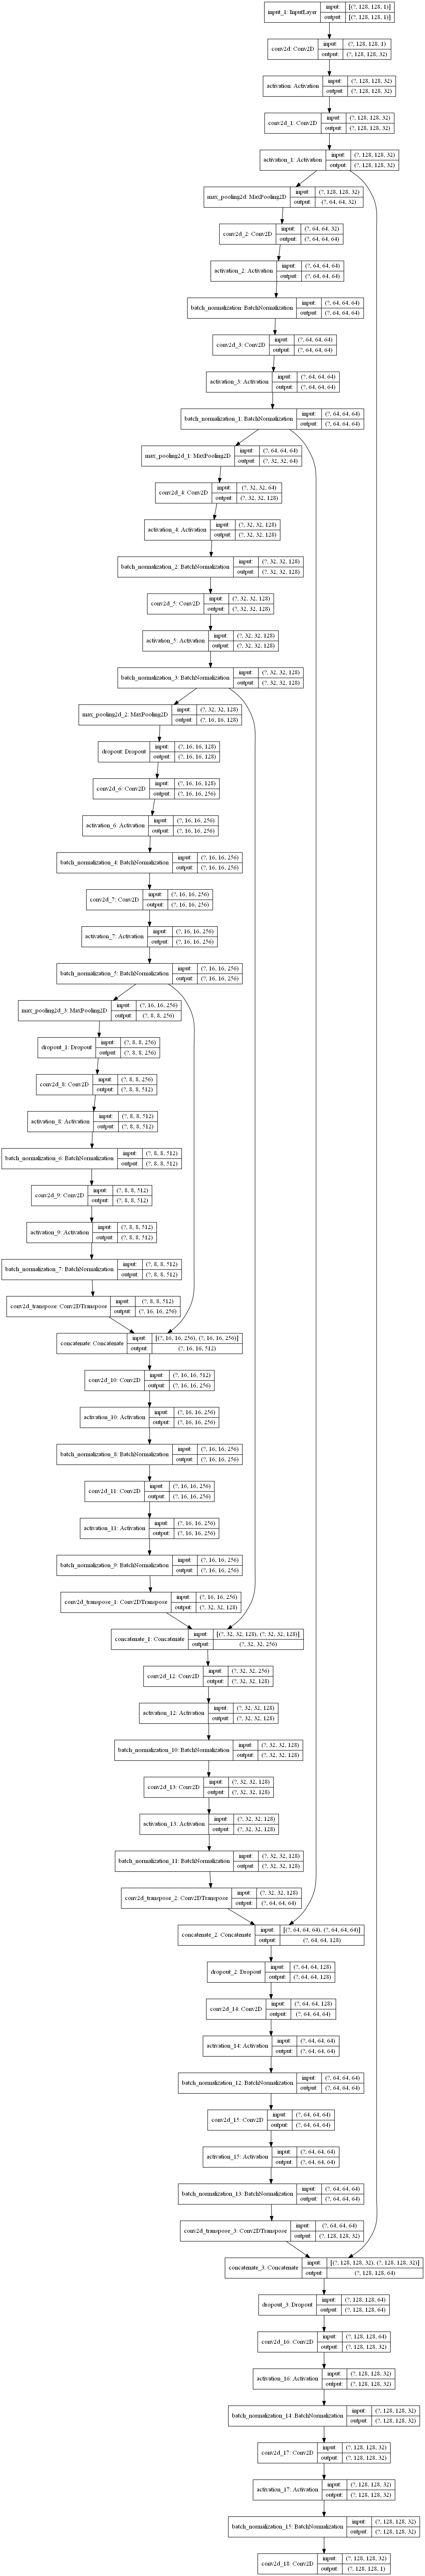

In [147]:

# Build your model.
model = build_model()

model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')


# NOTE: Are the input sizes correct?
# NOTE: Do you have the correct number of input images?
# NOTE: Are the output sizes correct?
# NOTE: Do you have the correct number of output images?
# NOTE: What's the range of the output? Can you use an activation as a regularizer?
# NOTE: Try to imagine the model layer-by-layer and think it through. Is it doing something reasonable?
# NOTE: Are your parameters split evenly inside the model? Try making "too large" layers smaller
# NOTE: Will the model fit into memory? Is the model too small? Is the model too large?

In [148]:
def dice_coef(y_true, y_pred, smooth=0.001):
    intersection = K.sum(y_true * y_pred, axis=[1, 2, 3])
    union = K.sum(K.square(y_true), axis=[1, 2, 3]) + K.sum(K.square(y_pred), axis=[1, 2, 3])
    # Note that we want to maximise the Dice coefficient, but if you want to use it as a loss you need the negative
    return K.mean((2.0 * intersection + smooth) / (union + smooth), axis = 0)

def dice_loss(smooth):
    def dice(y_true, y_pred):
        return 1.0 - dice_coef(y_true, y_pred, smooth)
    return dice

def dice_metric(smooth):
    def dice(y_true, y_pred):
        return dice_coef(y_true, y_pred)
    return dice

learning_rate = 0.001
dice_smooth = 0.0001
optim = optimizers.Adam(learning_rate=learning_rate)
custom_metric = dice_metric(dice_smooth)#'accuracy'

loss_func = keras.losses.BinaryCrossentropy(from_logits=False)
#loss_func = dice_loss(dice_smooth)
model.compile(
    loss=loss_func,
    optimizer=optim,
    metrics = [custom_metric]
 )

# NOTE: Are you satisfied with the optimizer and its parameters?
# NOTE: Try incorporating the DICE score into the model. Is it a loss function? Or a metric?

In [149]:
n_epochs = 50

training_loss = []
training_acc = []

validation_loss = []
validation_acc = []

for epoch in range(n_epochs):
    batches_training_loss = []
    batches_training_acc = []
    
    batches_validation_loss = []
    batches_validation_acc = []
    
    for batch in gen_train:
        X = batch[:-1]
        y = batch[-1]
        X_concat = np.concatenate(X, axis=0)
        y = [y for i in range(len(X))]
        y_concat = np.concatenate(y, axis=0)

        (batch_train_loss, batch_train_acc) = model.train_on_batch(X_concat, y_concat)
        batches_training_loss.append(batch_train_loss)
        batches_training_acc.append(batch_train_acc)
    
    for batch in gen_val:
        X = batch[:-1]
        y = batch[-1]
        X_concat = np.concatenate(X, axis=0)
        y = [y for i in range(len(X))]
        y_concat = np.concatenate(y, axis=0)

        (batch_validation_loss, batch_validation_acc) = model.test_on_batch(X_concat,y_concat)
        batches_validation_loss.append(batch_validation_loss)
        batches_validation_acc.append(batch_validation_acc)
        
    epoch_train_loss = np.mean(batches_training_loss)
    epoch_train_acc = np.mean(batches_training_acc)
    
    epoch_val_loss = np.mean(batches_validation_loss)
    epoch_val_acc = np.mean(batches_validation_acc)
    
    print(f"Epoch {epoch}, traininig: loss {epoch_train_loss:.4f} acc: {epoch_train_acc:.3f}, validation: loss {epoch_val_loss:.4f} acc: {epoch_val_acc:.3f}")
    
    training_loss.append(epoch_train_loss)
    training_acc.append(epoch_train_acc)
    
    validation_loss.append(epoch_val_loss)
    validation_acc.append(epoch_val_acc)
    
    gen_train.on_epoch_end()

    if epoch_val_acc > 0.8:
        break

# NOTE: Plotting the losses helps a lot.
# NOTE: What does plotting the training data tell you? Should you plot something else?
# NOTE: What should one do with the validation data? The fit_generator has a 'validation_data' argument as well.
# NOTE: When should one stop? Did you overtrain? Did you train for long enough?
# NOTE: Think about implementing Early Stopping?

Epoch 0, traininig: loss 0.0687 acc: 0.335, validation: loss 0.0485 acc: 0.279
Epoch 1, traininig: loss 0.0178 acc: 0.419, validation: loss 0.0286 acc: 0.464
Epoch 2, traininig: loss 0.0136 acc: 0.454, validation: loss 0.0379 acc: 0.371
Epoch 3, traininig: loss 0.0112 acc: 0.484, validation: loss 0.0212 acc: 0.513
Epoch 4, traininig: loss 0.0098 acc: 0.510, validation: loss 0.0274 acc: 0.528
Epoch 5, traininig: loss 0.0088 acc: 0.538, validation: loss 0.0231 acc: 0.522
Epoch 6, traininig: loss 0.0079 acc: 0.569, validation: loss 0.0311 acc: 0.589
Epoch 7, traininig: loss 0.0072 acc: 0.599, validation: loss 0.0329 acc: 0.526
Epoch 8, traininig: loss 0.0068 acc: 0.612, validation: loss 0.0301 acc: 0.591
Epoch 9, traininig: loss 0.0062 acc: 0.646, validation: loss 0.0258 acc: 0.614
Epoch 10, traininig: loss 0.0058 acc: 0.671, validation: loss 0.0225 acc: 0.581
Epoch 11, traininig: loss 0.0055 acc: 0.691, validation: loss 0.0231 acc: 0.643
Epoch 12, traininig: loss 0.0052 acc: 0.711, valid

KeyboardInterrupt: 

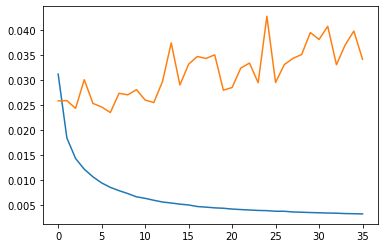

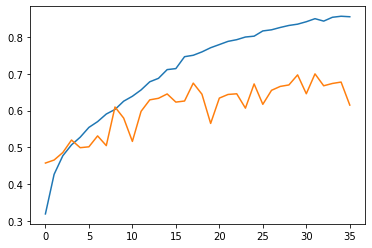

In [ ]:
n_epochs = len(training_loss)
epoch_arr = np.arange(0, n_epochs)

plt.plot(epoch_arr, training_loss)
plt.plot(epoch_arr, validation_loss)
plt.show()

plt.plot(epoch_arr, training_acc)
plt.plot(epoch_arr, validation_acc)

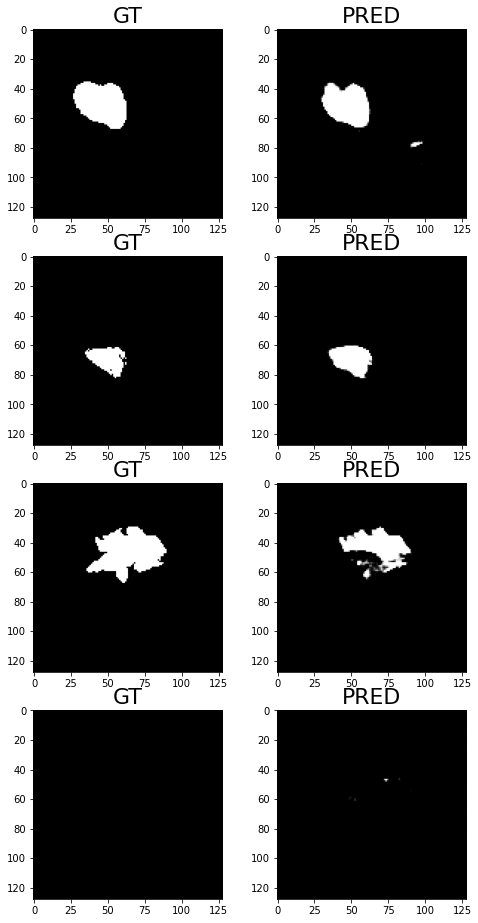

In [ ]:
batch = gen_val[np.random.randint(0, len(gen_val))]
X = batch[:-1]
y = batch[-1]
prediction = model.predict(X)

plt.figure(figsize=(8, 4*batch_size))
for idx in range(batch_size):
    plt.subplot(batch_size, 2, idx * 2 + 1)
    plt.imshow(y[idx, :, :], cmap='gray')
    plt.title('GT', fontsize=22)
    plt.subplot(batch_size, 2, idx * 2 + 2)
    plt.imshow(prediction[idx, :, :], cmap='gray')
    plt.title('PRED', fontsize=22)
    
# NOTE: What do the predictions mean? What values do they take?
# NOTE: How can your predictions be used as masks?

In [ ]:
# Test data
def get_full_dataset(generator):
    batch = generator[0]
    X = batch[:-1]
    y = batch[-1]
    y = [y for i in range(len(X))]
    full_inputs = np.concatenate(X, axis=0)
    full_masks = np.concatenate(y, axis=0)
    for idx, batch in enumerate(generator):
        if idx == 0:
            continue
    
        X = batch[:-1]
        a = np.concatenate(X, axis=0)
        full_inputs = np.concatenate((full_inputs, a), axis=0)

        y = batch[-1]
        y = [y for i in range(len(X))]
        a = np.concatenate(y, axis=0)
        full_masks = np.concatenate((full_masks, a), axis=0)
    
    return (full_inputs, full_masks)

inputs, masks = get_full_dataset(gen_val)
print(inputs.shape)
print(masks.shape)
final_results = model.evaluate(inputs, masks)
print(final_results)

(1000, 128, 128, 1)
(1000, 128, 128, 1)
32/32 [==============================] - 1s 29ms/step - loss: 0.0464 - dice: 0.6072
[0.04638949781656265, 0.6072449088096619]
